<a href="https://colab.research.google.com/github/Elman295/LSTM-Multi-Head-Attention-for-Spam-detection/blob/main/spam_detection_with_lstm_MHA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from torch import nn
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
import torchtext.transforms as T

In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

#`Data`

In [6]:
data_path = os.path.join("archive.zip")
with zipfile.ZipFile(data_path, "r") as f:
  f.extractall("data")

In [7]:
data_csv_path = os.path.join("data","spam.csv")
data = pd.read_csv(data_csv_path,encoding='latin1')
data.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
labels = data["v1"]
texts = data["v2"]

In [9]:
map_labels = {
    "ham":0,
    "spam":1
}
labels = labels.map(map_labels)

In [10]:
labels.head(5)

,v1
0,0
1,0
2,1
3,0
4,0


In [11]:
texts.head(5)

,v2
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,Ok lar... Joking wif u oni...
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,U dun say so early hor... U c already then say...
4,"Nah I don't think he goes to usf, he lives around here though"


In [12]:
len(texts)

5572

In [13]:
def find_max(texts):
  size = []
  for i in range(len(texts)):
    size.append(len(texts[i]))
  return max(size)


In [14]:
def find_min(texts):
  size = []
  for i in range(len(texts)):
    size.append(len(texts[i]))
  return min(size)

In [15]:
def find_avg(texts):
  sum = 0
  for i in range(len(texts)):
    sum += len(texts[i])
  return sum // len(texts)

In [16]:
find_max(texts)

910

In [17]:
find_min(texts)

2

In [18]:
find_avg(texts)

80

In [19]:
tokenizer = get_tokenizer("basic_english")

In [20]:
text = "Hello how are you?"
tokens = tokenizer(text)
tokens

['hello', 'how', 'are', 'you', '?']

In [21]:
def token_generator(texts):
  for text in texts:
    yield tokenizer(text)

In [22]:
vocab = build_vocab_from_iterator(
    iterator = token_generator(texts),
    specials = ["<pad>","<unk>"],
    special_first = True
)

In [23]:
vocab.set_default_index(vocab["<unk>"])

In [24]:
def string_2_vocab(text):
  return vocab(tokenizer(text))

In [25]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.ToTensor(),
    T.PadTransform(max_length =910, pad_value=0)
)

In [26]:
text = tokenizer("my name is Elman")
text_transform(text)

tensor([ 17, 267,  15,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

In [27]:
class Spam_dataset(Dataset):

  def __init__(self, text, label, text_transform = None):
    self.text = np.array(text)
    self.label = np.array(label)
    self.tfms = text_transform

  def __len__(self):
    return len(self.text)

  def __getitem__(self, idx):

    text = self.text[idx]
    label = self.label[idx]

    tokens = tokenizer(text)

    if self.tfms is not None:
      text = self.tfms(tokens)

    return text, torch.tensor(label).long()

In [28]:
text_ds = Spam_dataset(texts, labels, text_transform)

In [29]:
text,label = text_ds[0]
# print(text)
print(text.shape)
print(label)
print(label.dtype)

torch.Size([910])
tensor(0)
torch.int64


In [30]:
train_ds, test_ds = train_test_split(text_ds, test_size = 0.2, shuffle = True)
print(len(train_ds))
print(len(test_ds))

4457
1115


In [31]:
train_dl = DataLoader(dataset = train_ds, batch_size = 32, shuffle = True)
test_dl = DataLoader(dataset = test_ds, batch_size = 32, shuffle = False)


#`Model`

In [32]:
len(vocab)

9224

In [85]:
class LSTM(nn.Module):

  def __init__(self):
    super(LSTM, self).__init__()
    self.embed = nn.Embedding(len(vocab), embedding_dim=256)
    self.lstm = nn.LSTM(256,512,num_layers = 2, batch_first=True, bidirectional=True)
    self.attention = nn.MultiheadAttention(256,4, batch_first=True)
    self.mlp = nn.Linear(910* 512 * 2,2)

  def forward(self, x):

    embeded_input = self.embed(x)
    att,_ = self.attention(embeded_input, embeded_input, embeded_input)
    output,(h,c) = self.lstm(att)
    # output = output[:,-1,:]
    output = output.reshape(-1,910*2*512)
    output = self.mlp(output)
    return output

In [86]:
lstm = LSTM().to(device)
x = torch.randint(high = 9000, size = (19,910)).to(device)
y = lstm(x)
print(y.shape)

torch.Size([19, 2])


#`Training Loop`

In [87]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(params = lstm.parameters(), lr = 1e-3)

In [88]:
def train(data, model, loss_fn, opt):
  model.train()
  size = len(data.dataset)
  for b,(text,label) in enumerate(data):
    text,label = text.to(device), label.to(device)
    label_pred = model(text)
    loss = loss_fn(label_pred, label)
    opt.zero_grad()
    loss.backward()
    opt.step()

    if b % 100 == 0:
      print(f"loss:{loss.item()} [{b*len(x)} | {size}]")

In [89]:
def test(data, model, loss_fn):
  model.eval()
  size = len(data.dataset)
  num_batch = len(data)
  test_loss, test_acc = 0,0
  with torch.no_grad():
    for text,label in data:
      text, label = text.to(device), label.to(device)
      label_pred = model(text)
      test_loss += loss_fn(label_pred, label).item()
      test_acc += (label_pred.argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batch
    test_acc /= size

    print(f"loss test:{test_loss} acc:{test_acc*100}")

In [90]:
for e in range(5):
  print(f"epoch:{e+1}=-=-=-=-=")
  train(train_dl, lstm,loss_fn,opt)
  test(test_dl,lstm,loss_fn)

epoch:1=-=-=-=-=
loss:0.6817466616630554 [0 | 4457]
loss:0.033179134130477905 [1900 | 4457]
loss test:0.3779824060737155 acc:92.55605381165918
epoch:2=-=-=-=-=
loss:0.01905442774295807 [0 | 4457]
loss:0.17783509194850922 [1900 | 4457]
loss test:0.23448438870504365 acc:95.51569506726457
epoch:3=-=-=-=-=
loss:0.12211938202381134 [0 | 4457]
loss:6.3919533204170875e-06 [1900 | 4457]
loss test:0.5908044825707163 acc:90.67264573991032
epoch:4=-=-=-=-=
loss:1.0668672323226929 [0 | 4457]
loss:0.0006536685978062451 [1900 | 4457]
loss test:0.14280754990010922 acc:96.23318385650225
epoch:5=-=-=-=-=
loss:0.009141206741333008 [0 | 4457]
loss:0.028897468000650406 [1900 | 4457]
loss test:0.17058364301254705 acc:95.51569506726457


In [117]:
test_dl = DataLoader(dataset = test_ds, batch_size = 50, shuffle = False)

In [119]:
lstm.to("cpu")

LSTM(
  (embed): Embedding(9224, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (mlp): Linear(in_features=931840, out_features=2, bias=True)
)

In [120]:
text,label = next(iter(test_dl))
# text,label = text.to(device), label.to(device)
print(text.shape)
print(label.shape)

torch.Size([1115, 910])
torch.Size([1115])


In [ ]:
label_pred = lstm(text)
print(label_pred.shape)

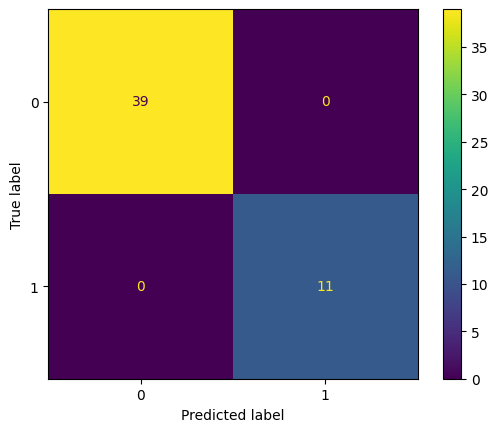

In [114]:
cm = confusion_matrix(label.cpu().numpy(),label_pred.argmax(1).cpu().detach().numpy())
ConfusionMatrixDisplay(cm).plot()